# Feature Selection in Data Science: A Hybrid Approach

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine, fetch_california_housing, load_breast_cancer, load_diabetes, make_regression
warnings.filterwarnings('ignore')


## Run Experiments


Wine Dataset Results:
Adaptive correlation threshold: 0.7436

Detailed Results:
                Our Method      RFE     PCA
mean_score          0.9721   0.9721  0.7079
std_score           0.0248   0.0176  0.0418
selection_time      0.3458  10.7946  0.0018
n_features         10.0000  13.0000  1.0000


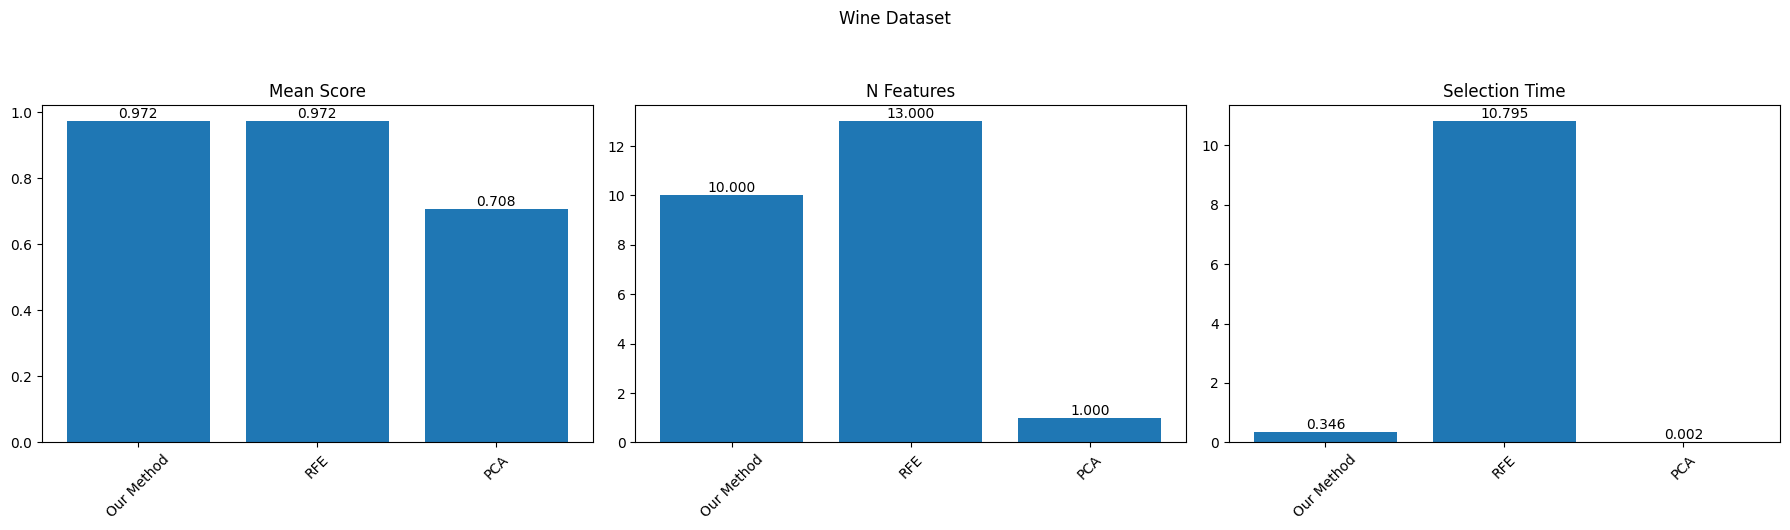


Generating Enhanced Visualizations...
Adaptive correlation threshold: 0.7436


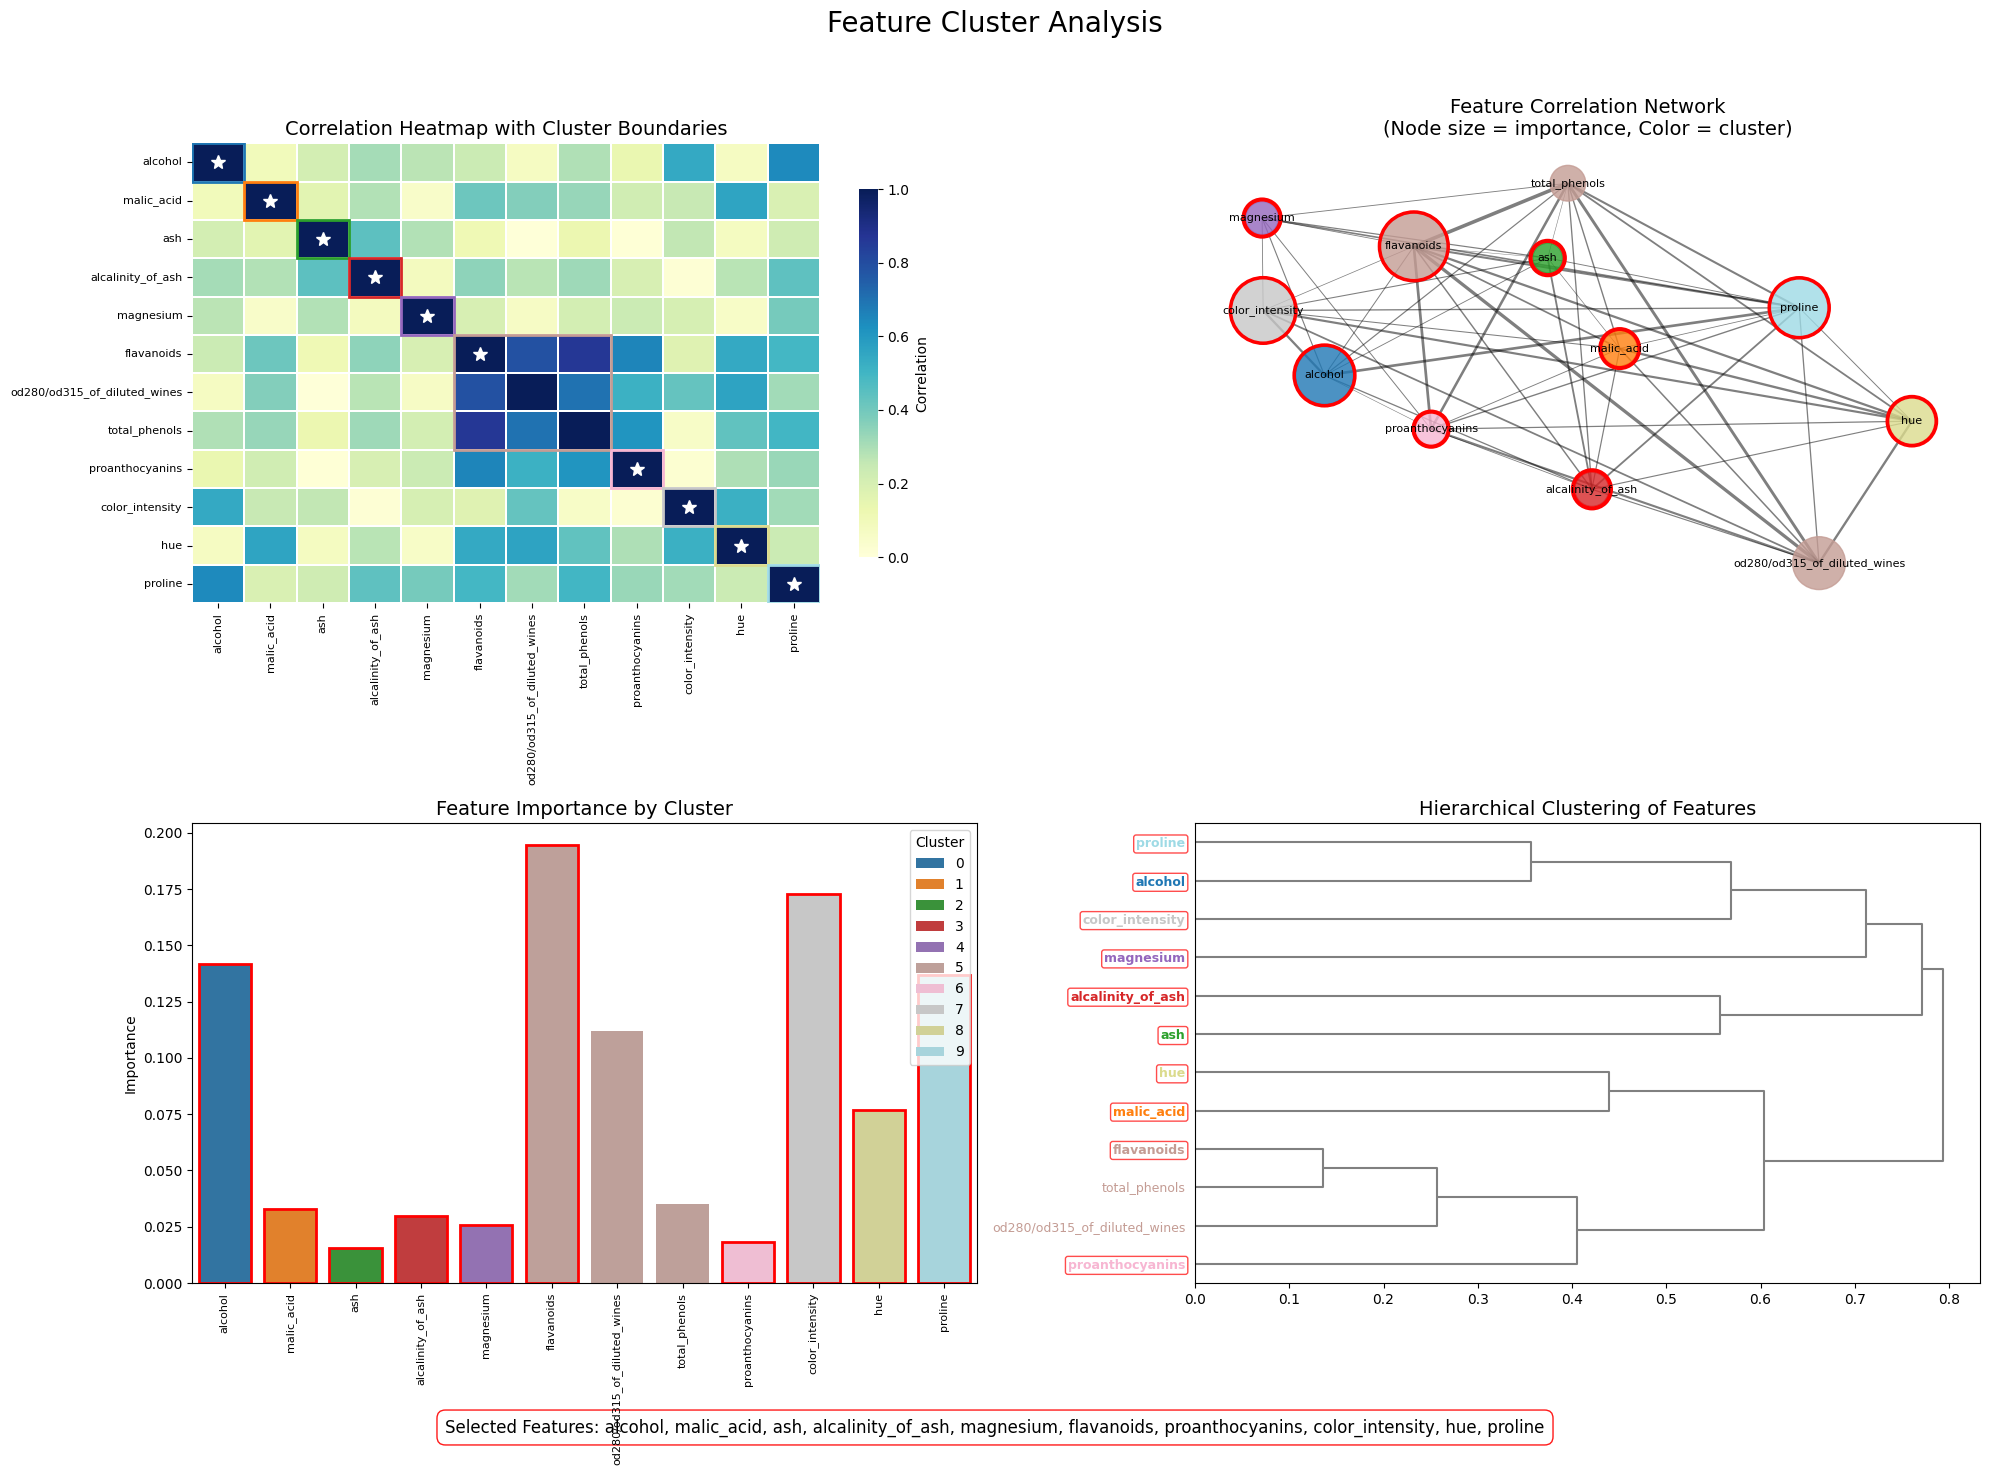


BreastCancer Dataset Results:
Adaptive correlation threshold: 0.9091


In [ ]:
from Evaluation_Functions import  compare_methods, plot_comparison, visualize_feature_clusters_enhanced
from FeatureSelector import FeatureSelector
def generate_large_regression_dataset(n_samples=3000, n_features=150, n_informative=15, 
                                     random_state=42, correlation_groups=5):
    """
    Generate a large synthetic regression dataset with correlated features.
    """
    
    
    # Generate base dataset with some informative features
    X_base, y = make_regression(n_samples=n_samples, 
                              n_features=n_informative,
                              n_informative=n_informative,
                              random_state=random_state)
    
    # Create column names for base features
    base_cols = [f'feature_{i}' for i in range(n_informative)]
    
    # Create a DataFrame from the base features
    X_df = pd.DataFrame(X_base, columns=base_cols)
    
    # Calculate how many derived/correlated features to add per group
    features_per_group = (n_features - n_informative) // correlation_groups
    
    # For each base feature, create several correlated versions with noise
    rng = np.random.RandomState(random_state)
    
    col_idx = n_informative
    for group in range(correlation_groups):
        # Select a random base feature to correlate with
        base_feature_idx = rng.randint(0, n_informative)
        base_feature = X_base[:, base_feature_idx]
        
        # Create correlated features for this group
        for i in range(features_per_group):
            # Add varying levels of noise
            noise_level = rng.uniform(0.1, 0.7)  # More noise = less correlation
            noise = rng.normal(0, noise_level, size=n_samples)
            
            # Create a correlated feature
            new_feature = base_feature + noise
            
            # Add some random scaling and shifting
            scale = rng.uniform(0.5, 2.0)
            shift = rng.uniform(-2.0, 2.0)
            new_feature = (new_feature * scale) + shift
            
            # Add the new feature to the DataFrame
            X_df[f'correlated_{col_idx}'] = new_feature
            col_idx += 1
    
    # Add remaining random noise features if needed
    remaining = n_features - col_idx
    if remaining > 0:
        X_noise = rng.normal(0, 1, size=(n_samples, remaining))
        noise_cols = [f'noise_{i+col_idx}' for i in range(remaining)]
        X_noise_df = pd.DataFrame(X_noise, columns=noise_cols)
        X_df = pd.concat([X_df, X_noise_df], axis=1)
    
    return X_df, y

# Create a compatible structure for the synthetic dataset
class SyntheticDataset:
    def __init__(self, X, y):
        self.data = X.values  # Convert DataFrame to numpy array
        self.target = y
        self.feature_names = X.columns.tolist()

# Generate and add the synthetic dataset
X_synth, y_synth = generate_large_regression_dataset()
synth_dataset = SyntheticDataset(X_synth, y_synth)

# Prepare datasets
datasets = {
    'Wine': (load_wine(), 'classification'),
    'BreastCancer': (load_breast_cancer(), 'classification'),
    'Housing': (fetch_california_housing(), 'regression'),
    ##take 3 hours to run with the rfe so if you want to run you should remove the rfe from the methods in the Evaluation functions in the compare_method 'SynthRegression': (synth_dataset, 'regression')
}

# Run experiments
for name, (data, task) in datasets.items():
    print(f"\n{name} Dataset Results:")
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = data.target
    
    # Standard evaluation
    results = compare_methods(X, y, task)
    print("\nDetailed Results:")
    print(pd.DataFrame(results).round(4))
    
    # Plot comparisons
    plot_comparison(results, f'{name} Dataset')
    
    # Add this section to create and fit a selector for visualization
    print("\nGenerating Enhanced Visualizations...")
    # Create and fit the selector
    selector = FeatureSelector(task_type=task, n_clusters=None, 
                              importance_threshold=0.01)
    selector.fit(X, y)
    
    # Generate enhanced visualizations
    fig = visualize_feature_clusters_enhanced(selector, X)
    plt.savefig(f"{name}_cluster_visualization.png", dpi=300, bbox_inches='tight')
    plt.show()